Optical properties of responsive hybrid Au@polymer nanoparticles
========

Must change title eventually

Supporting information - data analysis: import & initial plots
--------

Abstract
--------

We take a close look at the physical and optical properties of Au@PNIPAM core-shell nanoparticles.
- Small Au cores, radius $\sim$ 8.5 nm
- Wide range of shell thickness, 15 to 200 nm
- Two shell architectures: 
    - grafted/linear, thin range: [16, 65] nm
    - seeded-precipitation/cross-linked, thick range: [50, 193] nm
- Studied with UV-vis, DLS, SLS, TEM

# Table of Contents
* [1. Initialize analysis](#1.-Initialize-analysis)
	* [1.1 Initialize computational/python framework](#1.1-Initialize-computational/python-framework)
	* [1.2 Import data](#1.2-Import-data)
		* [1.2.1 Linear PNIPAM](#1.2.1-Linear-PNIPAM)
		* [1.2.2 Cross-linked PNIPAM](#1.2.2-Cross-linked-PNIPAM)
		* [1.2.3 Combine data sets](#1.2.3-Combine-data-sets)
* [2. Initial plots](#2.-Initial-plots)
	* [2.1 Spectra line plots](#2.1-Spectra-line-plots)
	* [2.2 $R_h$ vs temperature](#2.2-$R_h$-vs-temperature)
	* [2.3 Absorbance vs. temperature vs. wavelength (3D color)](#2.3-Absorbance-vs.-temperature-vs.-wavelength-%283D-color%29)
	* [2.4 Absorbance vs $R_h$ vs wavelength (3D/color)](#2.4-Absorbance-vs-$R_h$-vs-wavelength-%283D/color%29)


# 1. Initialize analysis

## 1.1 Initialize computational/python framework

In [531]:
%run "header.py"

Loading import modules ...
Loading analysis codes ... 
  ... refractive index functions loaded:
       Au, Ag, SiO2, ITO, ZnO, H2O, 
       ethanol, CS2, benzene, toluene, 
       chloroform, methanol, butanol, 
       propanol
  ... Mie functions loaded
  ... local Mie functions loaded
Ready player one.


In [532]:
%run "header_parallel.py"

Initializing cluster ...
   Client variable 'kernels'
   Cluster Direct View variable 'cluster'
   Variable 'nKernels' = 3
importing mie on engine(s)
importing mie_local on engine(s)
importing refractive_index_library on engine(s)


## 1.2 Import data

### 1.2.1 Linear PNIPAM

In [533]:
print("Import and organize data")
print("========================")
folderName = 'data_20160905'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
spectraNames = []
spectraTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 0
    if (fileName == 'Au-linPNIPAM-long-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-medium-hydr-radius.dat'
        or fileName == 'Au-linPNIPAM-short-hydr-radius.dat'): 
        headerLines = 3
    elif (fileName == 'Au-linPNIPAM-long.dat'
          or fileName == 'Au-linPNIPAM-medium.dat'
          or fileName == 'Au-linPNIPAM-short.dat'): 
        headerLines = 2
        columnNames = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', dtype=str, comments='\\', skip_header=0, max_rows=1)[1:-1]
        spectraNames.append(columnNames.tolist())
        temps = []
        for name in columnNames:
            temps.append(float(name[-5:-3]))
        spectraTemps.append(temps)
        #print(columnNames)
    else: headerLines = 2
    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    return tempData
data = list(map(importData,fileNames))

# Last column indicates sample shell thickness:
# 2 = long (thick)
# 1 = medium
# 0 = short (thin)
print("Oganizing data ...")
dataList = []
spectraLRhnms = []
for i in range(3):
    sampleNum = 2-i
    dlsData = data[2*i]
    spectraData0 = data[2*i+1]
    temps = spectraTemps[i]
    hydroRs = []
    for T in temps:
        aList = list(zip(dlsData[:,0], dlsData[:,1], np.abs(dlsData[:,0] - T)))
        dtype = [('T',float), ('Rh',float), ('dT',float)]
        anArray = np.array(aList, dtype=dtype)
        anArray = np.sort(anArray, order='dT')[0:3]
        subset = []
        for pt in anArray:
            subset.append(pt[1])
        rh = np.mean(subset)
        hydroRs.append(rh)
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), sampleNum ]
            dataList.append(dataPoint)
            spectraLRhnms.append(hydroRs)
dataLArray = np.asarray(dataList)
spectraLTemps = spectraTemps
print("  * extrapolate hydrodynamic radius from DLS to UV-Vis temps")
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 2 = thick shell, 1 = medium, 0 = thin")

# Au cores only
spectrumCore = data[-1]
print("  * core alone sorted separately")

print("Done.")

Import and organize data
Importing data in folder data_20160905 ...
  * Au-linPNIPAM-long-hydr-radius.dat
  * Au-linPNIPAM-long.dat
  * Au-linPNIPAM-medium-hydr-radius.dat
  * Au-linPNIPAM-medium.dat
  * Au-linPNIPAM-short-hydr-radius.dat
  * Au-linPNIPAM-short.dat
  * AW5.txt
Oganizing data ...
  * extrapolate hydrodynamic radius from DLS to UV-Vis temps
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 2 = thick shell, 1 = medium, 0 = thin
  * core alone sorted separately
Done.


A spectrum plot to make sure everything imported correctly.

Sample spectrum


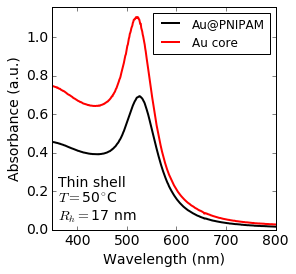

In [534]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Selection ranges
    sampleNum, tempC = 0, 49
    wlMin, wlMax = 350, 800
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(dataLArray[:,-3],np.abs(tempC - dataLArray[:,-3])))
    dtype = [('T',float),('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    tempC = np.sort(anArray, order='dT')[0][0]
    selection = (dataLArray[:,0] >= wlMin) & (dataLArray[:,0] <= wlMax) & (dataLArray[:,-3] == tempC) & (dataLArray[:,-1] == sampleNum)
    plotArray = dataLArray[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    Rhnm = plotArray[0,-2]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['Thin','Med.','Thick'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(int(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics/" + timestamp + "_sample-spectrum" + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### 1.2.2 Cross-linked PNIPAM

In [535]:
print("Import and organize data")
print("========================")
folderName = 'data_20160906'
fileNames = []
print("Importing data in folder",folderName,"...")
for file in os.listdir(folderName):
    #if file.endswith('.dat'): 
        fileNames.append(file)
spectraXTemps = []
def importData(fileName):
    print("  *",fileName)
    headerLines = 3
    if (fileName == 'temperature-calibration.dat'): 
        headerLines = 2
    if (fileName == 'Au-xPNIPAM-long.dat'
          or fileName == 'Au-xPNIPAM-medium.dat'
          or fileName == 'Au-xPNIPAM-short.dat'): 
        temps = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=2, max_rows=1)[1:-1]
        temps = temps.tolist()
        spectraXTemps.append(temps)
        #print(temps)

    tempData = np.genfromtxt(folderName+'/'+fileName, delimiter='\t', skip_header=headerLines)
    # print(tempData)
    return tempData
data = list(map(importData,fileNames))

tempConvert = interpolate.interp1d(data[-1][:,0], data[-1][:,1], kind="cubic")
aListOfLists = spectraXTemps
spectraXTemps = []
for i in range(3):
    aList = []
    for ii in range(len(aListOfLists[i])):
        newTemp = (tempConvert(aListOfLists[i][ii])).tolist()
        aList.append(newTemp)
    spectraXTemps.append(aList)

# Last column indicates sample shell thickness:
# 5 = long (thick)
# 4 = medium
# 3 = short (thin)
print("Oganizing data ...")
dataXList = []
spectraXRhnms = []
for i in range(3):
    sampleNum = int(3 + 2-i)
    dlsData = data[1+2*i]
    spectraData0 = data[1+2*i+1]
    temps = spectraXTemps[i]
    hydroRs = []
    for T in temps:
        aList = list(zip(dlsData[:,0], dlsData[:,1], np.abs(dlsData[:,0] - T)))
        dtype = [('T',float), ('Rh',float), ('dT',float)]
        anArray = np.array(aList, dtype=dtype)
        anArray = np.sort(anArray, order='dT')[0:3]
        subset = []
        for pt in anArray:
            subset.append(pt[1])
        rh = np.mean(subset)
        hydroRs.append(rh)
    for ii in range(len(temps)):
        for iii in range(len(spectraData0)):
            dataPoint = [ spectraData0[iii,0], spectraData0[iii,ii+1], temps[ii], hydroRs[ii].tolist(), sampleNum ]
            dataXList.append(dataPoint)
            spectraXRhnms.append(hydroRs)
dataXArray = np.asarray(dataXList)
print("  * extrapolate hydrodynamic radius from DLS to UV-Vis temps")
print("  * organized as [ wl-nm, abs, temp, Rh, sample-# ]")
print("  * sample 5 = thick shell, 4 = medium, 3 = thin")

# Au cores only
spectrumXCore = data[0]
print("  * core alone sorted separately")

print("Done.")

Import and organize data
Importing data in folder data_20160906 ...
  * Au-core-only-for-xPNIPAM.dat
  * Au-xPNIPAM-long-hydr-radius.dat
  * Au-xPNIPAM-long.dat
  * Au-xPNIPAM-medium-hydr-radius.dat
  * Au-xPNIPAM-medium.dat
  * Au-xPNIPAM-short-hydr-radius.dat
  * Au-xPNIPAM-short.dat
  * temperature-calibration.dat
Oganizing data ...
  * extrapolate hydrodynamic radius from DLS to UV-Vis temps
  * organized as [ wl-nm, abs, temp, Rh, sample-# ]
  * sample 5 = thick shell, 4 = medium, 3 = thin
  * core alone sorted separately
Done.


A spectrum plot to make sure everything imported correctly.

Sample spectrum


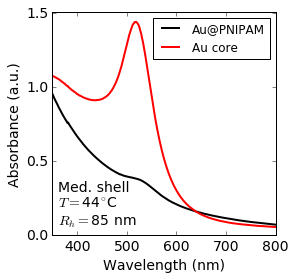

In [536]:
print('Sample spectrum')
print('===============')
def plotAndSave ():   
    ## Selection ranges
    sampleNum, tempC = 4, 45
    wlMin, wlMax = 350, 800
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(dataXArray[:,-3],np.abs(tempC - dataXArray[:,-3])))
    dtype = [('T',float),('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    tempC = np.sort(anArray, order='dT')[0][0]
    selection = (dataXArray[:,0] >= wlMin) & (dataXArray[:,0] <= wlMax) & (dataXArray[:,-3] == tempC) & (dataXArray[:,-1] == sampleNum)
    plotArray = dataXArray[selection]
    Rhnm = plotArray[0,-2]
    x, y = plotArray[:,0], plotArray[:,1]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumXCore[:,0] >= wlMin) & (spectrumXCore[:,0] <= wlMax)
    plotArray = spectrumXCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['Thin','Med.','Thick','Thin','Med.','Thick'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(int(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(int(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    filename = "graphics/" + timestamp + "_sample-spectrum" + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
plotAndSave() 


### 1.2.3 Combine data sets

In [537]:
dataList = dataLArray.tolist()
for i in range(len(dataXArray)): dataList.append(dataXArray[i])
dataArray = np.asarray(dataList)

spectraCores = np.array([spectrumCore, spectrumXCore])
coreRnms = [17/2, 13.2/2]

spectraTemps = []
spectraRhnms = []
for sampleNum in range(6):
    print(sampleNum,':')
    selection = (dataArray[:,-1] == sampleNum)
    temps = np.unique( (dataArray[selection])[:,-3] )
    Rhnms = []
    for T in temps:
        selection = (dataArray[:,-1] == sampleNum) & (dataArray[:,-3] == T)
        RhOfT = np.unique( (dataArray[selection])[:,-2] ) 
        print('  ', T, RhOfT[0])
        Rhnms.append( RhOfT[0] )
    Rhnms = np.asarray(Rhnms)
    print('(',temps.size, 'x',Rhnms.size,')')
    spectraTemps.append(temps)
    spectraRhnms.append(Rhnms)
spectraTemps = np.asarray(spectraTemps)
spectraRhnms = np.asarray(spectraRhnms)

0 :
   15.0 24.7666666667
   20.0 23.1888888889
   25.0 23.8
   27.0 23.8222222222
   29.0 23.4
   31.0 21.8111111111
   33.0 20.6666666667
   35.0 20.9333333333
   40.0 18.5777777778
   45.0 18.1222222222
   50.0 17.6555555556
   55.0 18.6222222222
   60.0 17.8777777778
( 13 x 13 )
1 :
   15.0 43.2
   20.0 41.8888888889
   25.0 39.2777777778
   27.0 37.9888888889
   29.0 36.9111111111
   31.0 33.8888888889
   33.0 29.5555555556
   35.0 28.0555555556
   40.0 27.2333333333
   45.0 26.7777777778
   50.0 26.7611111111
   55.0 26.0111111111
   60.0 26.4777777778
( 13 x 13 )
2 :
   15.0 65.0222222222
   20.0 64.1555555556
   25.0 61.7444444444
   27.0 59.0555555556
   29.0 56.4222222222
   31.0 53.1111111111
   33.0 45.8333333333
   35.0 42.6111111111
   40.0 38.0222222222
   45.0 39.4333333333
   50.0 39.1333333333
   55.0 39.2888888889
( 12 x 12 )
3 :
   7.65 82.1502847344
   9.96 81.5246415465
   13.81 79.7910253029
   17.66 78.1176669192
   21.51 75.960939485
   25.36 71.3064301507
   2

# 2. Initial plots

## 2.1 Spectra line plots

### vs. wavelength

All spectra
 with Au core in red for reference


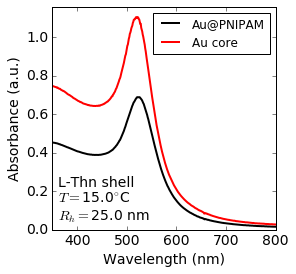

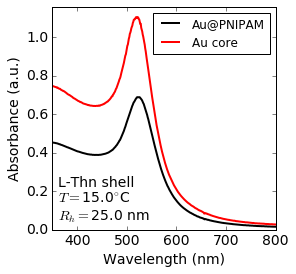

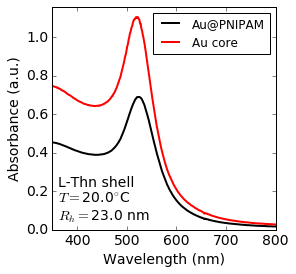

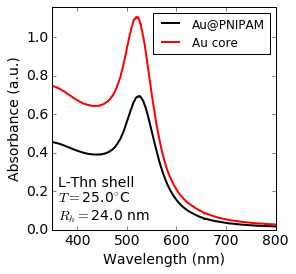

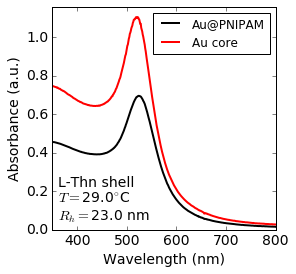

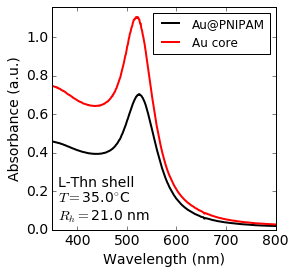

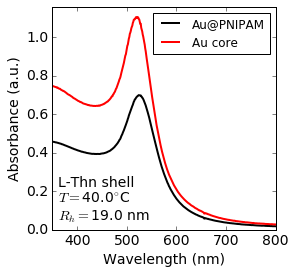

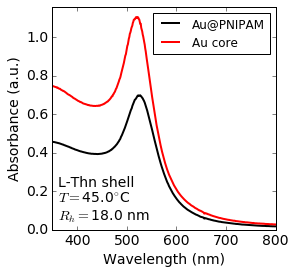

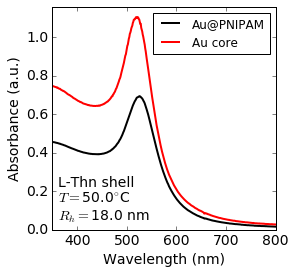

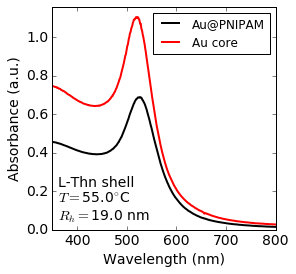

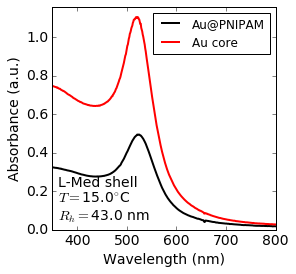

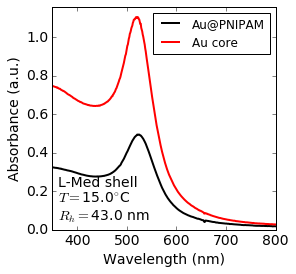

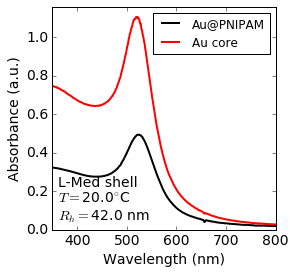

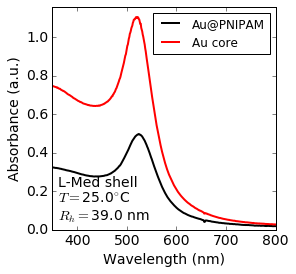

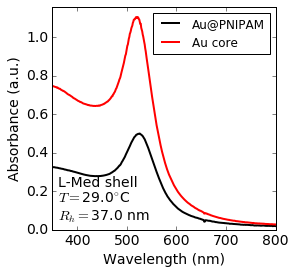

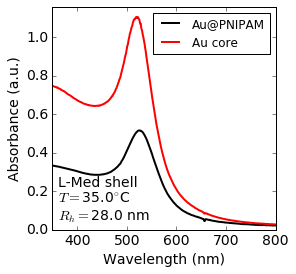

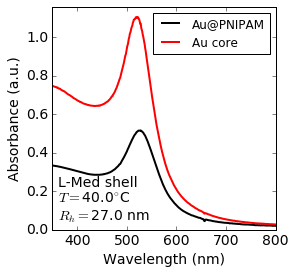

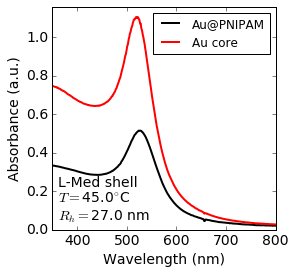

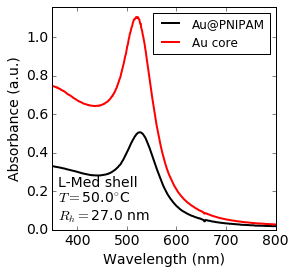

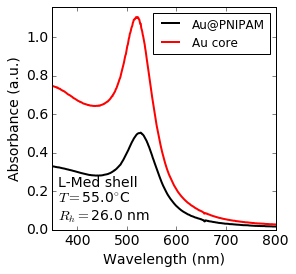

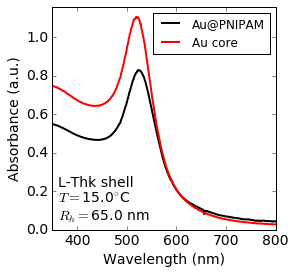

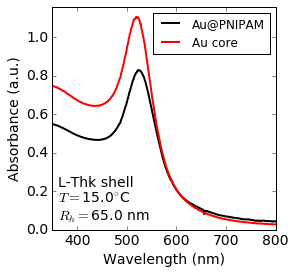

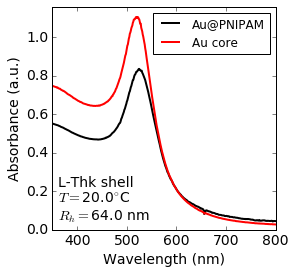

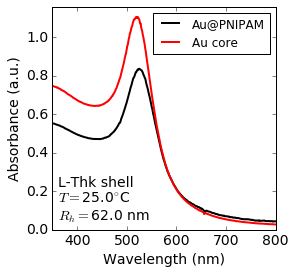

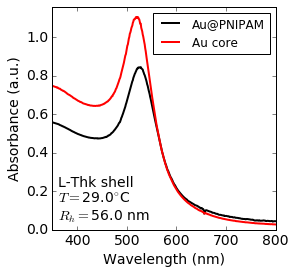

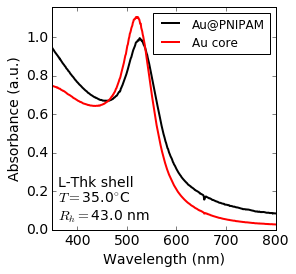

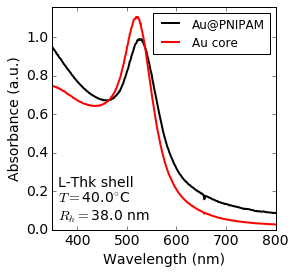

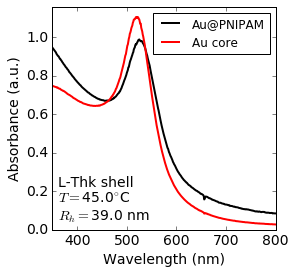

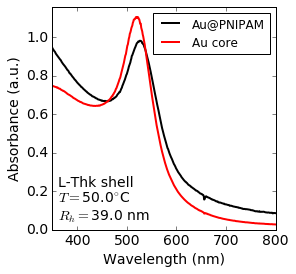

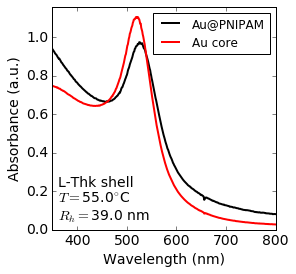

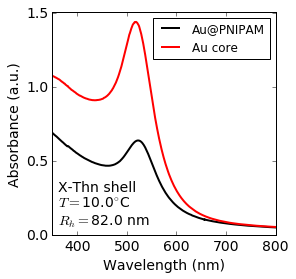

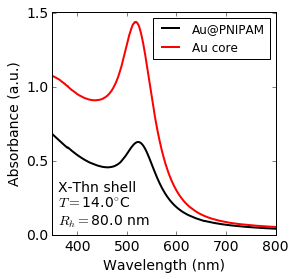

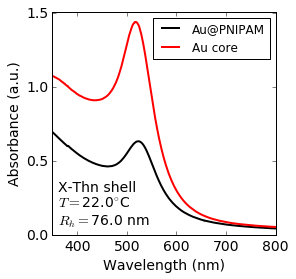

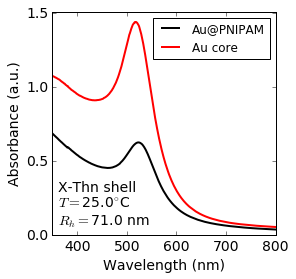

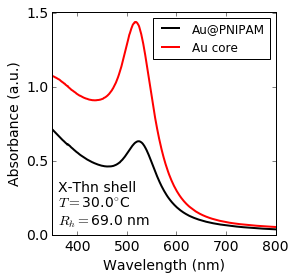

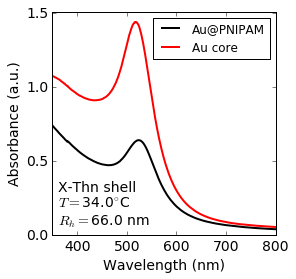

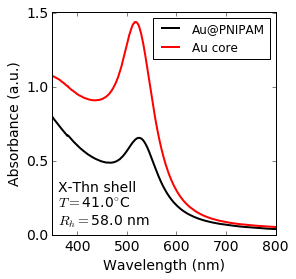

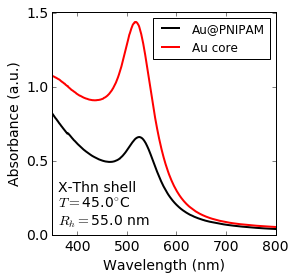

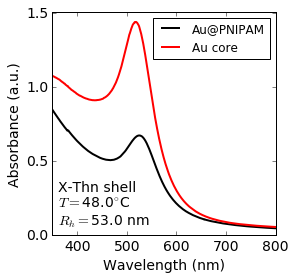

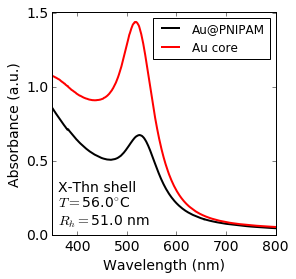

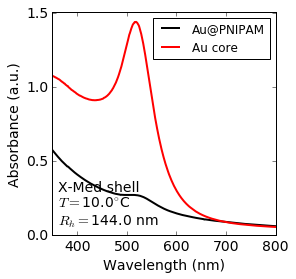

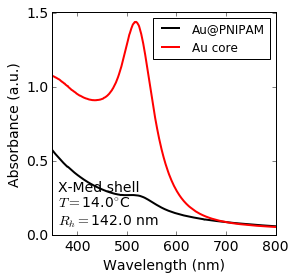

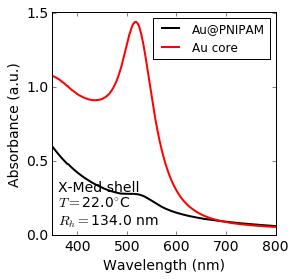

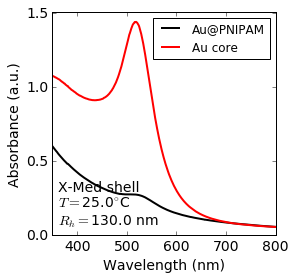

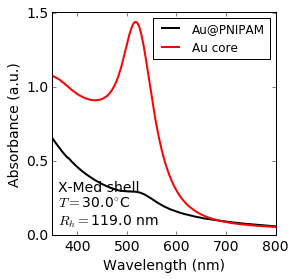

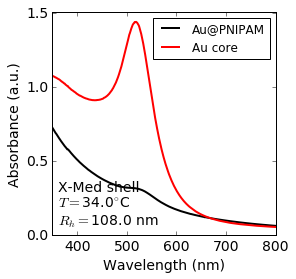

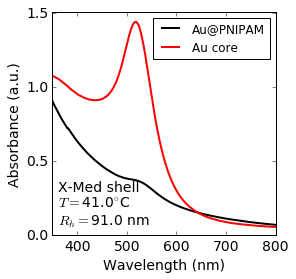

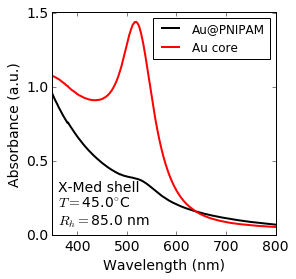

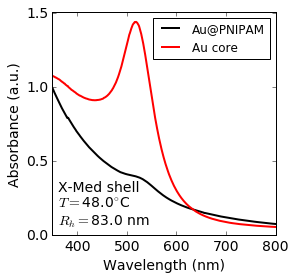

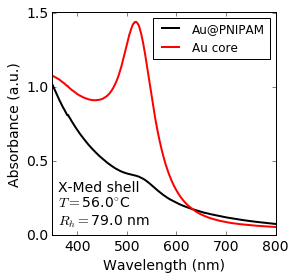

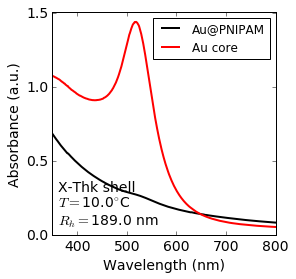

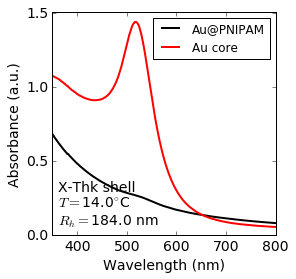

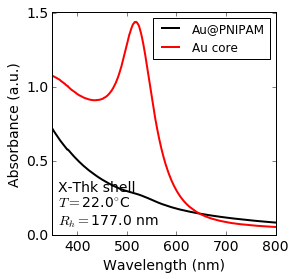

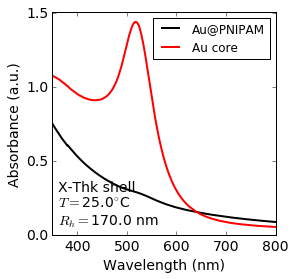

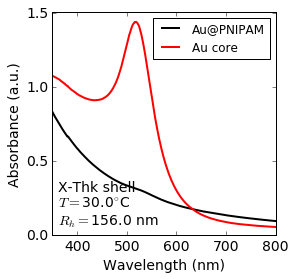

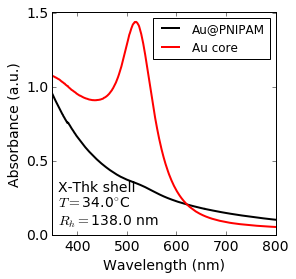

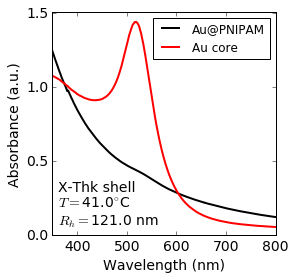

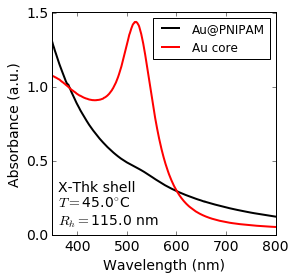

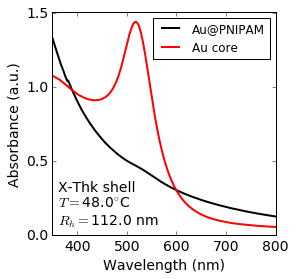

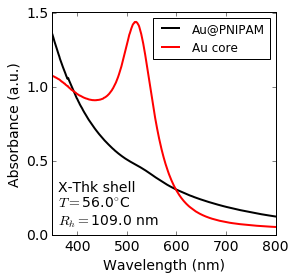

In [538]:
print('All spectra')
print('===========')
print(' with Au core in red for reference')
def plotAndSave (sampleNum, tempC):   
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(tempList, RhnmList, np.abs(tempC - tempList)))
    dtype = [('T',float), ('Rh',float), ('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    closestTemp = np.sort(anArray, order='dT')[0]
    tempC, Rhnm = closestTemp[0], closestTemp[1]
    selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-3] == tempC) & (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(round(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(round(Rhnm))+' nm')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectrum-"
                  + ['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]
                  + '-T='+str(round(tempC))+'C')
    filename = "graphics/" + timestamp + identifier + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6):
    for tempC in range(10,60,5):
        plotAndSave(sampleNum, tempC) 


### vs. scattering parameter $2\pi r/\lambda$

All spectra
 with Au core in red for reference
 vs scaterring parameter x = 2*pi*n*r/wl
  - n = [1.35, 1.45], estimated from Rh


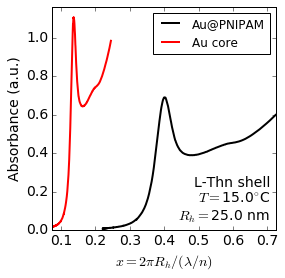

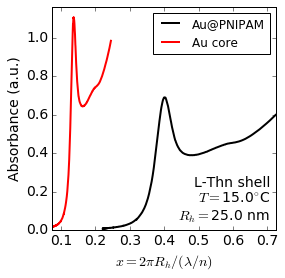

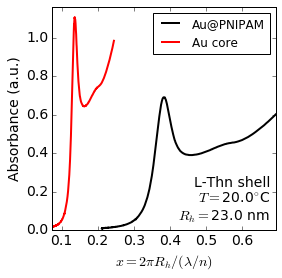

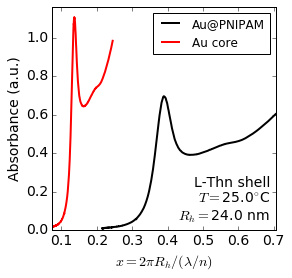

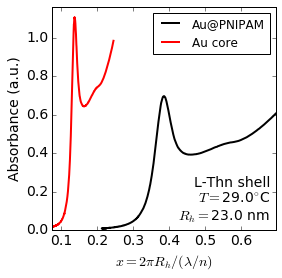

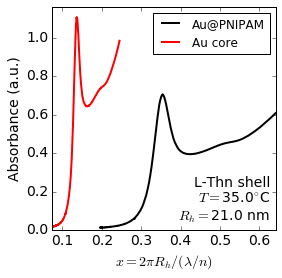

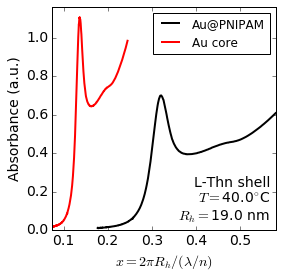

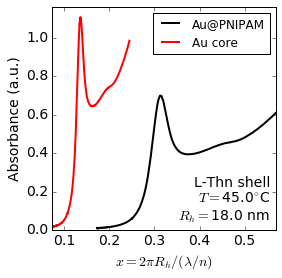

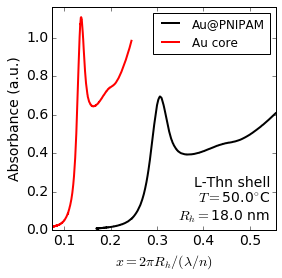

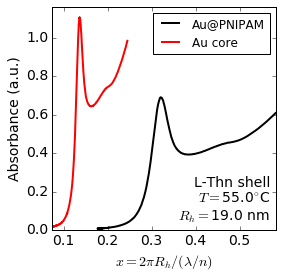

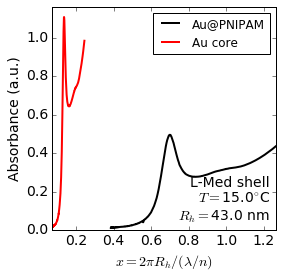

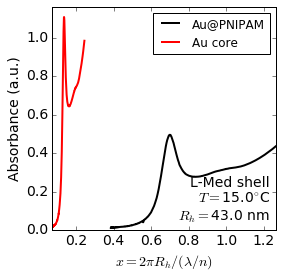

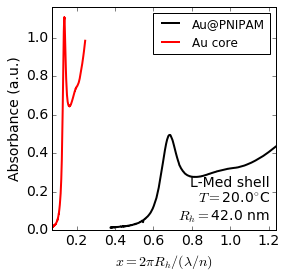

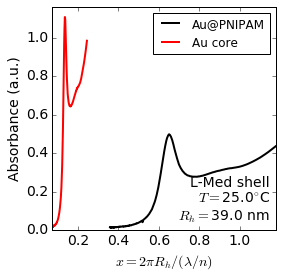

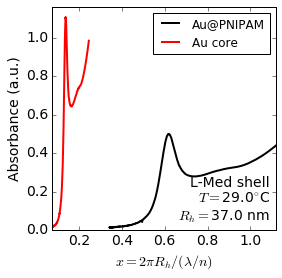

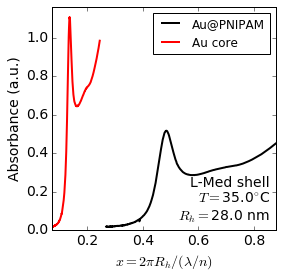

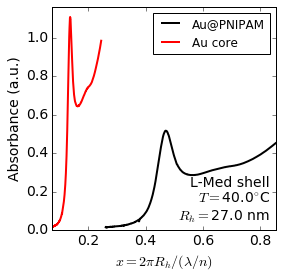

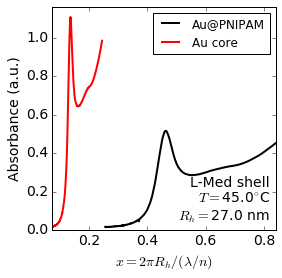

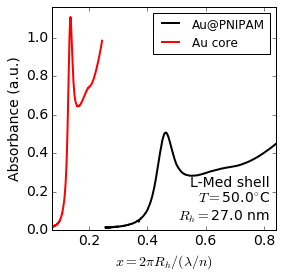

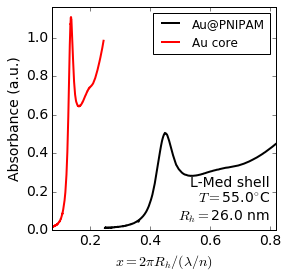

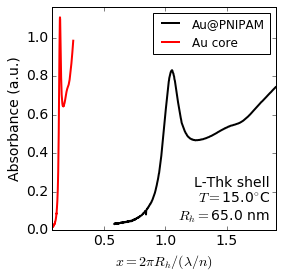

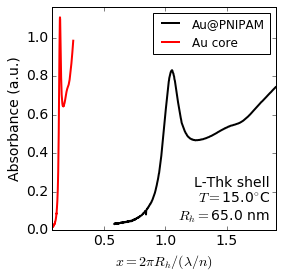

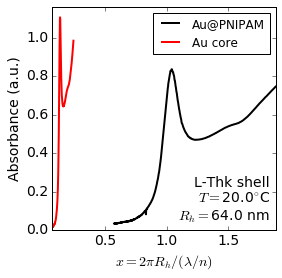

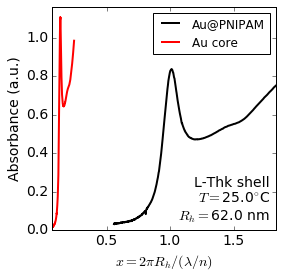

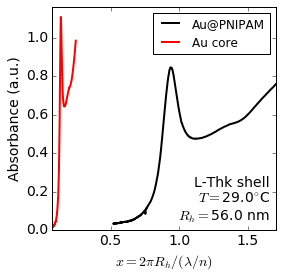

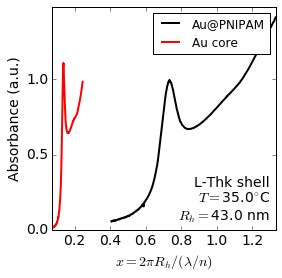

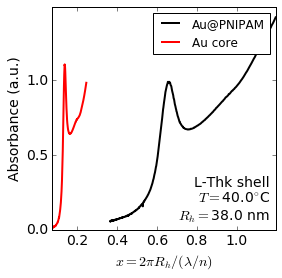

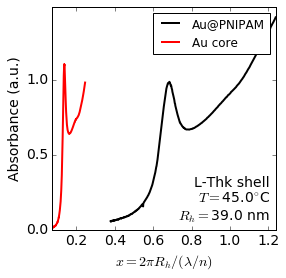

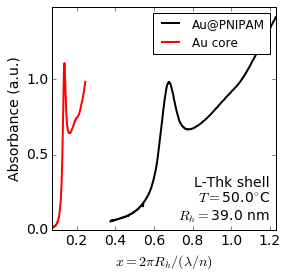

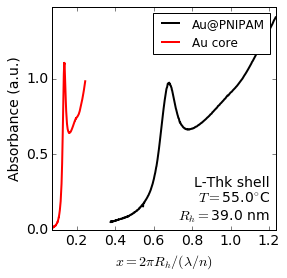

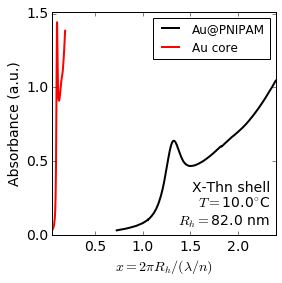

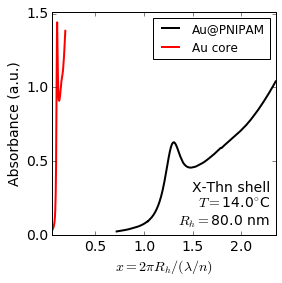

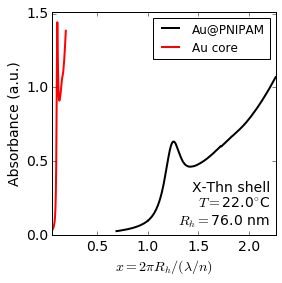

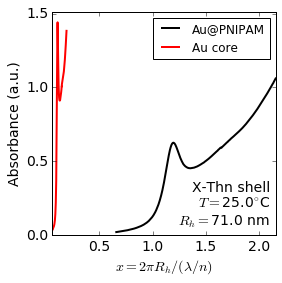

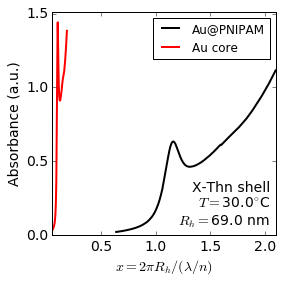

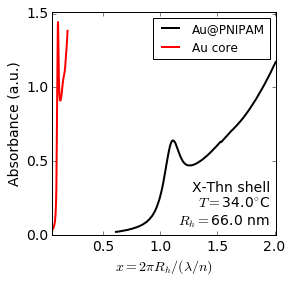

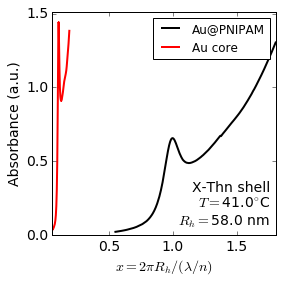

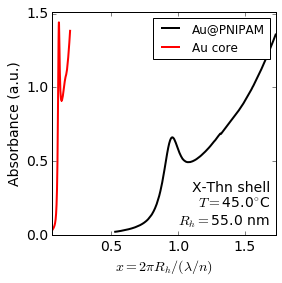

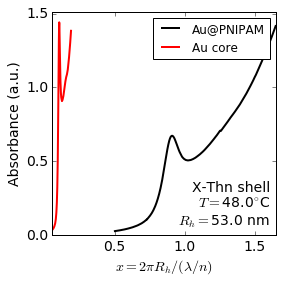

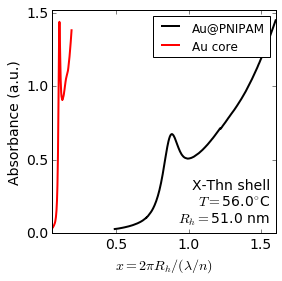

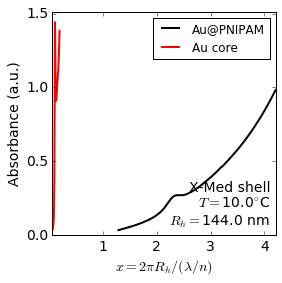

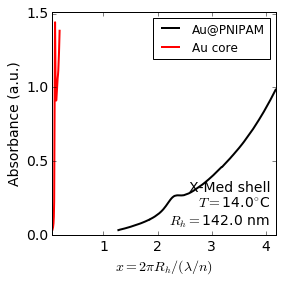

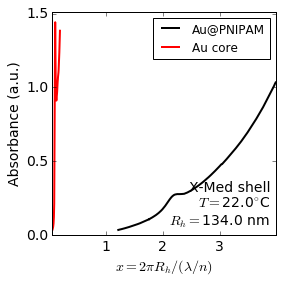

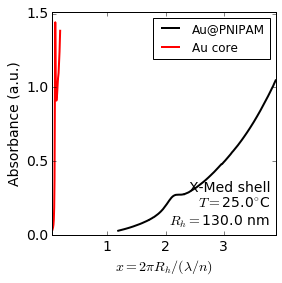

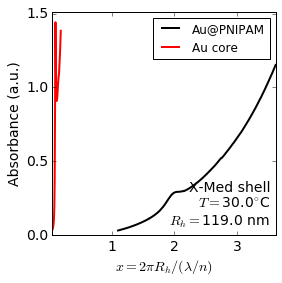

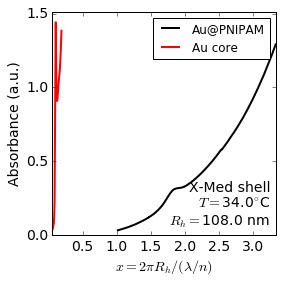

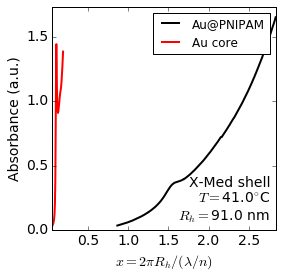

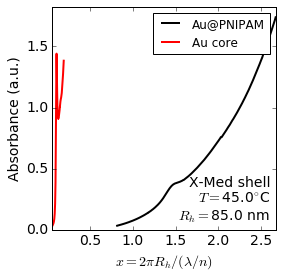

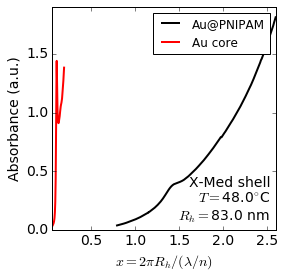

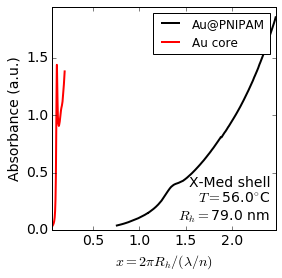

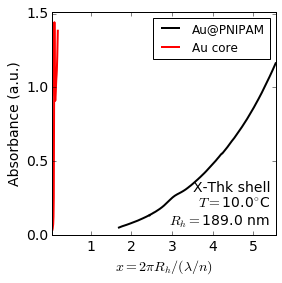

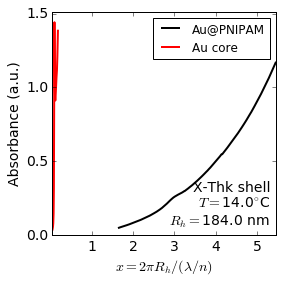

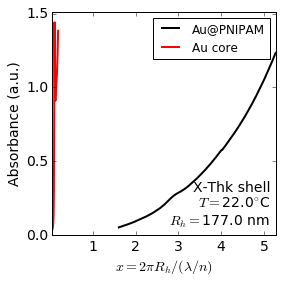

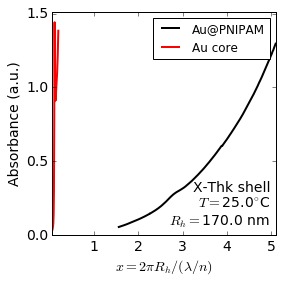

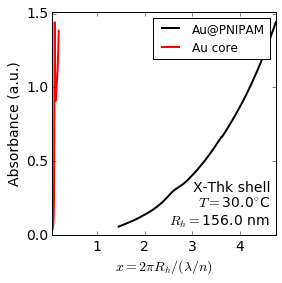

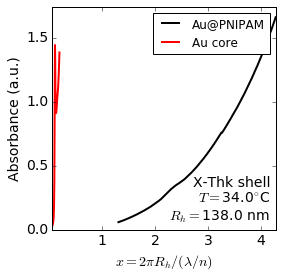

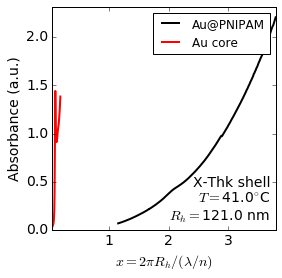

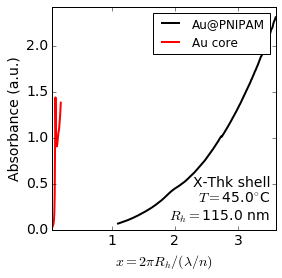

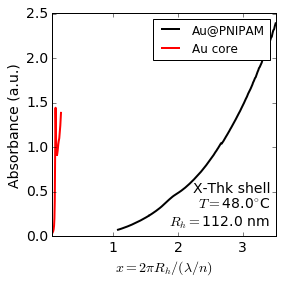

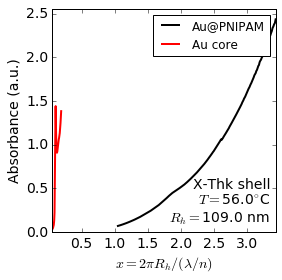

In [545]:
print('All spectra')
print('===========')
print(' with Au core in red for reference')
print(' vs scaterring parameter x = 2*pi*n*r/wl')
print('  - n = [1.35, 1.45], estimated from Rh')
def plotAndSave (sampleNum, tempC):   
    ## Selection ranges
    wlMin, wlMax = 290, 950
    
    coreNum = 0
    if sampleNum >= 3: coreNum = 1
    spectrumCore = spectraCores[coreNum]
    rCorenm = coreRnms[coreNum]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    Vminnm3 = (RhnmList[0]**3 - rCorenm**3)
    Vmaxnm3 = (RhnmList[-1]**3 - rCorenm**3)
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    aList = list(zip(tempList, RhnmList, np.abs(tempC - tempList)))
    dtype = [('T',float), ('Rh',float), ('dT',float)]
    anArray = np.array(aList, dtype=dtype)
    closestTemp = np.sort(anArray, order='dT')[0]
    tempC, Rhnm = closestTemp[0], closestTemp[1]
    Vnm3 = (Rhnm**3 - rCorenm**3)
    phi = (Vnm3 - Vminnm3)/(Vmaxnm3 - Vminnm3)
    selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-3] == tempC) & (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    ri = 1.35 + phi*(1.45 - 1.35)
    x = 2*pi*Rhnm/(x/ri)
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    # data set 2
    label = 'Au core'
    color = 'red'
    selection = (spectrumCore[:,0] >= wlMin) & (spectrumCore[:,0] <= wlMax)
    plotArray = spectrumCore[selection]
    x, y = plotArray[:,0], plotArray[:,1]
    x = 2*pi*rCorenm/(x/1.33)
    xs.append(x), ys.append(y), labels.append(label), colors.append(color)
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y)*0, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("$x = 2\pi R_h/(\lambda/n)$")
    pylab.ylabel("Absorbance (a.u.)")
    figText = (['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]+' shell'+'\n'
        +'$T=$'+str(round(tempC))+'$^{\circ}$C'+'\n'
        + '$R_h=$'+str(round(Rhnm))+' nm')
    pylab.text(xLimits[1]-0.025*dx, yLimits[0]+0.025*dy, figText, 
               verticalalignment='bottom', horizontalalignment='right')
    pylab.legend(loc='upper right', fontsize=12)
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectrum-"
                  + ['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]
                  + '-T='+str(round(tempC))+'C')
    filename = "graphics/" + timestamp + identifier + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6):
    for tempC in range(10,60,5):
        plotAndSave(sampleNum, tempC) 


## 2.2 $R_h$ vs temperature

Hydrodynamic radius vs temperature


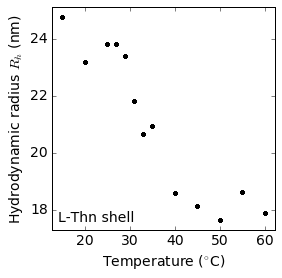

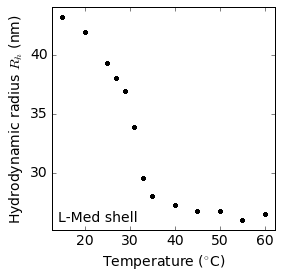

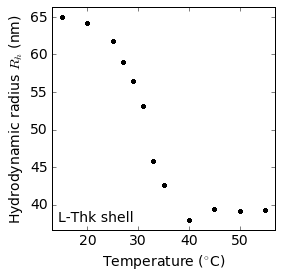

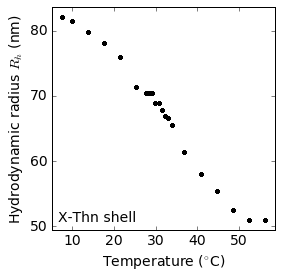

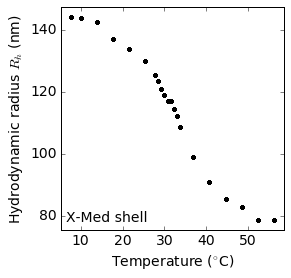

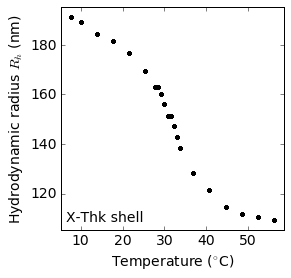

In [10]:
print('Hydrodynamic radius vs temperature')
print('===========')
def plotAndSave (sampleNum):   
    ## Selection ranges    
    spectrumCore = []
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set 1
    label = 'Au@PNIPAM'
    color = 'black'
    selection = (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    x, y = plotArray[:,-3], plotArray[:,-2]
    xs, ys, labels, colors = [x], [y], [label], [color]
    
    ## Plot lines & set limits
    nSets = len(xs)
    for setNum in range(nSets):
        pylab.plot(xs[setNum], ys[setNum], '.', label=labels[setNum], color=colors[setNum], linewidth=2)
    x, y = [], []
    for setNum in range(nSets):
        for i in range(len(xs[setNum])): 
            x.append(xs[setNum][i]); y.append(ys[setNum][i])
    xLimits = [np.amin(x), np.amax(x)]
    yLimits = [np.amin(y), np.amax(y)]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    xLimits = [np.amin(x)- 0.05*dx, np.amax(x)+ 0.05*dx]
    yLimits = [np.amin(y)- 0.05*dy, np.amax(y)+ 0.05*dy]
    dx, dy = abs(xLimits[1]-xLimits[0]), abs(yLimits[1]-yLimits[0])
    
    ## Specific format options
    pylab.xlabel("Temperature ($^{\circ}$C)")
    pylab.ylabel("Hydrodynamic radius $R_h$ (nm)")
    figText = (['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]+' shell')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("swelling-radius-"
                 + ['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]
                 +'_')
    filename = "graphics/" + timestamp + identifier + exportFormat
    # pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6): 
    plotAndSave(sampleNum) 


## 2.3 Absorbance vs. temperature vs. wavelength (3D color)

Extinction efficiency
3D/color graphs by shell type/thickness
Exported to:
 graphics/20160920_spectra3D-vs-T_L-Thn.svg


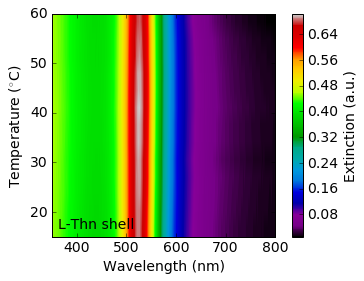

Exported to:
 graphics/20160920_spectra3D-vs-T_L-Med.svg


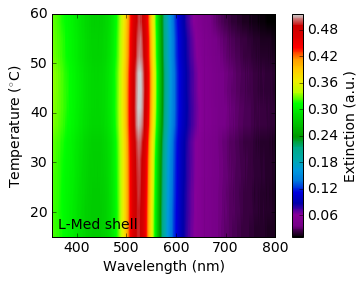

Exported to:
 graphics/20160920_spectra3D-vs-T_L-Thk.svg


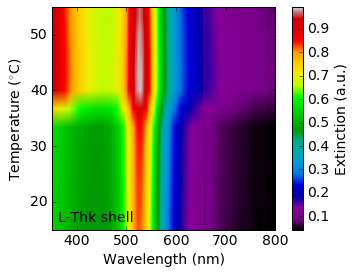

Exported to:
 graphics/20160920_spectra3D-vs-T_X-Thn.svg


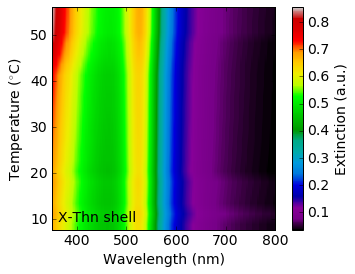

Exported to:
 graphics/20160920_spectra3D-vs-T_X-Med.svg


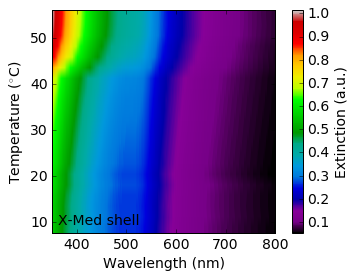

Exported to:
 graphics/20160920_spectra3D-vs-T_X-Thk.svg


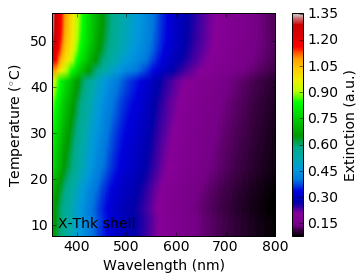

In [11]:
print('Extinction efficiency')
print('3D/color graphs by shell type/thickness')
print('=================================')

def plotAndSave (sampleNum):   
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set
    label = 'Au@PNIPAM'
    color = 'black'
    selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    # wl, temp, absorbance
    x, y, z = plotArray[:,0], tempList, plotArray[:,1]
    
    ## Plot lines & set limits
    x = np.unique(x)
    xLimits = [x[0], x[-1]]
    yLimits = [y[0], y[-1]]
    zLimits = [np.amin(z), np.amax(z)]
    dx, dy = xLimits[1] - xLimits[0], yLimits[1] - yLimits[0]
    z = np.reshape(z, (y.size, x.size))
    plot = pylab.imshow(z,extent=(xLimits[0],xLimits[1],yLimits[1],yLimits[0]),cmap=cm.spectral)
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Temperature ($^{\circ}$C)")
    zLabel = 'Extinction (a.u.)'
    figText = (['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]+' shell')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    aspectRatio = dx/dy
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    cb = pylab.colorbar(plot,orientation='vertical')
    cb.set_label(zLabel)
        
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectra3D-vs-T_"
                  + ['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6):
    plotAndSave(sampleNum) 

## 2.4 Absorbance vs $R_h$ vs wavelength (3D/color)

Extinction efficiency
3D/color graphs by shell type/thickness
Exported to:
 graphics/20160920_spectra3D-vs-Rh_L-Thn.svg


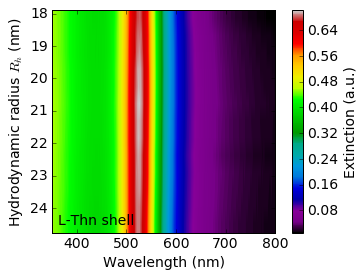

Exported to:
 graphics/20160920_spectra3D-vs-Rh_L-Med.svg


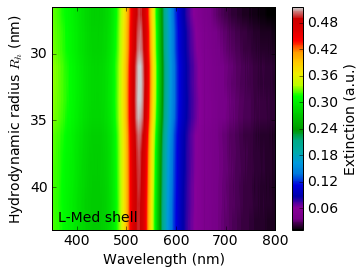

Exported to:
 graphics/20160920_spectra3D-vs-Rh_L-Thk.svg


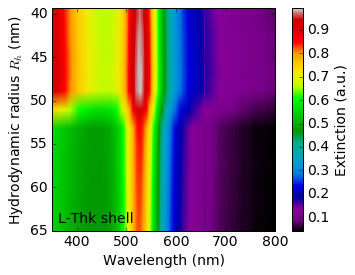

Exported to:
 graphics/20160920_spectra3D-vs-Rh_X-Thn.svg


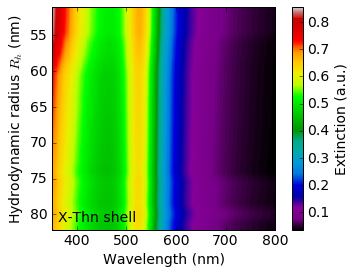

Exported to:
 graphics/20160920_spectra3D-vs-Rh_X-Med.svg


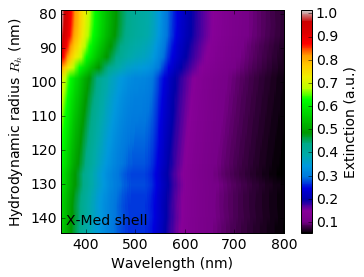

Exported to:
 graphics/20160920_spectra3D-vs-Rh_X-Thk.svg


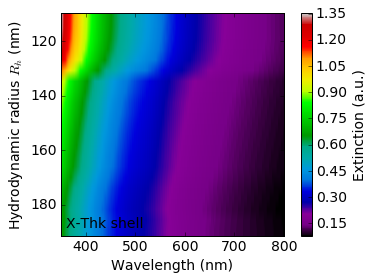

In [12]:
print('Extinction efficiency')
print('3D/color graphs by shell type/thickness')
print('=================================')

def plotAndSave (sampleNum):   
    ## Selection ranges
    wlMin, wlMax = 350, 800
    
    spectrumCore, tempList, sampleType = [], [], ''
    if sampleNum < 3: 
        spectrumCore = spectraCores[0]
    else: 
        spectrumCore = spectraCores[1]
    tempList = spectraTemps[sampleNum]
    RhnmList = spectraRhnms[sampleNum]
    
    # data set
    label = 'Au@PNIPAM'
    color = 'black'
    selection = (dataArray[:,0] >= wlMin) & (dataArray[:,0] <= wlMax) & (dataArray[:,-1] == sampleNum)
    plotArray = dataArray[selection]
    # wl, temp, absorbance
    x, y, z = plotArray[:,0], RhnmList, plotArray[:,1]
    
    ## Plot lines & set limits
    x = np.unique(x)
    xLimits = [x[0], x[-1]]
    yLimits = [y[0], y[-1]]
    zLimits = [np.amin(z), np.amax(z)]
    dx, dy = xLimits[1] - xLimits[0], yLimits[1] - yLimits[0]
    z = np.reshape(z, (y.size, x.size))
    plot = pylab.imshow(z,extent=(xLimits[0],xLimits[1],yLimits[1],yLimits[0]),cmap=cm.spectral)
    
    ## Specific format options
    pylab.xlabel("Wavelength (nm)")
    pylab.ylabel("Hydrodynamic radius $R_h$ (nm)")
    zLabel = 'Extinction (a.u.)'
    figText = (['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum]+' shell')
    pylab.text(xLimits[0]+0.025*dx, yLimits[0]+0.025*dy, figText, verticalalignment='bottom', horizontalalignment='left')
    
    ## More general format options
    aspectRatio = abs(dx/dy)
    figWidthcm = [8.46, 17.78][0] # ACS 1- and 2- column sizes
    figSizein = [figWidthcm/2.54, aspectRatio*figWidthcm/2.54]
    fig = pylab.figure(1, figsize=(figSizein[0],figSizein[1]))
    pylab.subplot(111)
    pylab.rcParams.update({'font.size': 14})
    pylab.axes().set_aspect(aspectRatio)
    pylab.xlim(xLimits[0], xLimits[1])
    pylab.ylim(yLimits[0], yLimits[1])
    pylab.locator_params(nbins=7)
    cb = pylab.colorbar(plot,orientation='vertical')
    cb.set_label(zLabel)
        
    ## Save and display
    timestamp = ('{:%Y%m%d}'.format(datetime.datetime.now()))
    exportFormat = '.svg'
    identifier = ("_spectra3D-vs-Rh_"
                  + ['L-Thn','L-Med','L-Thk','X-Thn','X-Med','X-Thk'][sampleNum])
    filename = "graphics/" + timestamp + identifier + exportFormat
    pylab.savefig(filename); print("Exported to:\n", filename)
    pylab.show()
    
for sampleNum in range(6):
    plotAndSave(sampleNum) 